In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import yt
import sys
sys.path.insert(0,'/home/cjlee/practice/athena/vis/python')
import athena_read
from astropy.io import ascii
import matplotlib as mpl
from astropy import units as au
from astropy.table import QTable
from astropy import constants as const
sys.path.insert(0,'/home/cjlee')
from for_hii import hii
from add_fields_hii import add_fields
import yt.units as yu
yc = yt.physical_constants
from mpl_toolkits.axes_grid1 import AxesGrid
import pickle
import os
from mpl_toolkits.axes_grid1 import ImageGrid,Grid
from scipy.optimize import curve_fit
mpl.rcParams['font.size'] = 16
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

path_='/data/cjlee/hii/various_nH0_Qi/vesc_test3'
datapath=Path(path_)
pathlist2=list(datapath.glob('hii*'))

In [2]:
path1='/data/cjlee/hii/various_nH0_Qi/grav_test/nx_128'
datapath=Path(path1)
pathlist1=list(datapath.glob('hii*'))
for i in range(len(pathlist1)):
    print(i,pathlist1[i])

0 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q49.0n2.0_nx_128_fdt_0.1_navg_15
1 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q50.0n2.0_nx_128_fdt_0.1_navg_15
2 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q50.0n3.0_nx_128_fdt_0.1_navg_15
3 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q49.0n1.0_nx_128_fdt_0.1_navg_15
4 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15
5 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q51.0n2.0_nx_128_fdt_0.1_navg_15
6 /data/cjlee/hii/various_nH0_Qi/grav_test/nx_128/hii_Q50.0n1.0_nx_128_fdt_0.1_navg_15


## 1. models in parameter space

In [3]:
def para_space(model_list):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=[0.5,0.03]))
    norm =  mpl.colors.LogNorm(1e+47,1e+53)
    cmap = mpl.cm.plasma

    ##lines: v_esc,n,r
    M_line = np.logspace(4,7,100)
    Sig_min,Sig_max = 10, 1000
    for fixed_r in [10,20]:
        fixed_r_Sig = M_line/np.pi/fixed_r**2
        axes[0].plot(M_line,fixed_r_Sig,'k--',ms=1)
        ind = np.where((fixed_r_Sig>=Sig_min)&(fixed_r_Sig<=Sig_max))
        axes[0].text(M_line[ind][0]*1.2,fixed_r_Sig[ind][0]*0.99,'r='+str(fixed_r)+'pc'
                     ,fontsize=12,rotation=50)
    for fixed_nH in [100,1000]:
        muH = yc.mass_hydrogen.to(yu.Msun)*1.4
        fixed_nH_r=((3*M_line/(4*np.pi*fixed_nH*muH))**(1/3))*(1*yu.cm).to(yu.pc)
        fixed_nH_Sig=M_line/np.pi/fixed_nH_r.value**2
        axes[0].plot(M_line,fixed_nH_Sig,'k--',ms=1)
        ind = np.where((fixed_nH_Sig>=Sig_min)&(fixed_nH_Sig<=Sig_max))
        axes[0].text(M_line[ind][-1]*0.25,fixed_nH_Sig[ind][-1]*0.5,'$n_H$='+str(fixed_nH)+'$cm^{-3}$'
                     ,fontsize=12,rotation=21)
    for fixed_vesc in [5,10]:
        fixed_vesc_r = (2*yc.G*M_line*yu.M_sun/(fixed_vesc*yu.km/yu.s)**2).to(yu.pc)
        fixed_vesc_Sig=M_line/np.pi/fixed_vesc_r.value**2
        axes[0].plot(M_line,fixed_vesc_Sig,'k--',ms=1)
        ind = np.where((fixed_vesc_Sig>=Sig_min)&(fixed_vesc_Sig<=Sig_max))
        axes[0].text(M_line[ind][-1]*0.5,fixed_vesc_Sig[ind][-1]*1
                     ,'$v_{esc,0}$='+str(fixed_vesc)+'km/s',fontsize=12,rotation=-50)
    for model in model_list:
        s = pa.LoadSim(str(model))
        nH = s.par['problem']['nH0']
        r = s.par['problem']['r0']
        Qi = s.par['problem']['Qi']
        M = 4*np.pi/3*s.u.muH*nH*r**3*s.u.mass
        Sig = M/np.pi/r**2
        axes[0].plot(M,Sig,'o',ms=7,c=cmap(norm(Qi)))

    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('$M(M_{sun})$')
    axes[0].set_ylabel('$\Sigma (M_{sun}/pc^2)$')
    axes[0].set_xlim(1e+4,1e+7)
    axes[0].set_ylim(1e+1,1e+3)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, cax=axes[-1], label='Qi($s^{-1}$)')
    return

<>:43: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_179910/3534461086.py:43: SyntaxWarning: invalid escape sequence '\S'
  axes[0].set_ylabel('$\Sigma (M_{sun}/pc^2)$')


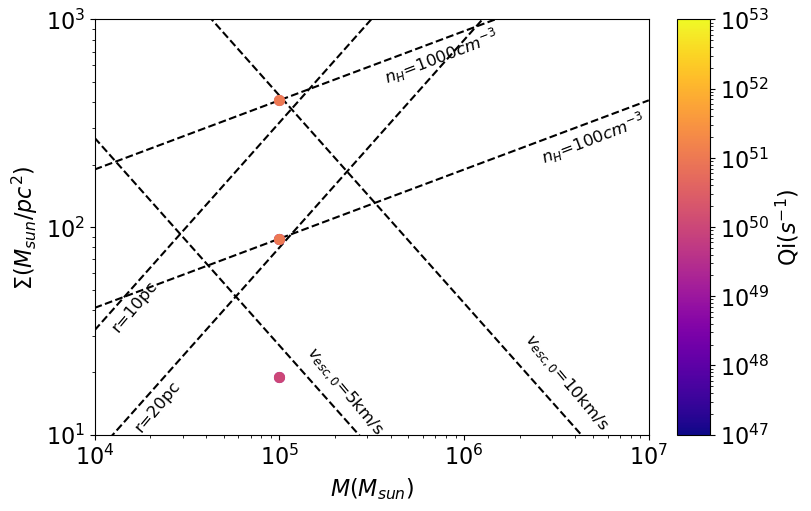

In [4]:
para_space(pathlist1)

## 2. snapshot

In [4]:
def t_find(model):
    s = pa.LoadSim(str(model))
    h = pa.read_hst(s.files['hst'])
    Mneu = h['mass_neu']/h['mass_neu'][0]
    result = [s.par['problem']['t0_src']]
    for perc in [0.75,0.5,0.1]:
        t = np.min(h['time'][Mneu<=perc])
        result.append(t)        
    tarr=np.array([])
    for num in s.nums:
        ds = s.load_hdf5(num,load_method='yt')
        t = ds.current_time
        tarr=np.hstack([tarr,t])
    t_ind=[]
    for  tt in result:
        t_ind.append(np.where(tarr==np.min(tarr[tarr>=tt]))[0][0])
    return t_ind

In [5]:
def snapshot(model):
    s = pa.LoadSim(str(model))
    t_ind = t_find(model)
    fig = plt.figure(figsize=(17,20))
    ImGrids=[]
    steps=t_find(pathlist1[0])
    fields = [('density'),('vr'),('Er_rayt0')]
    nrow,ncol=len(steps),len(fields)
    aux={}
    aux['density']={'cmap':'viridis','cmin':1e-1,'cmax':1e+3,'title':'density'}
    aux['vr']={'cmap':'RdBu_r','cmin':-30,'cmax':30,'title':'radial velocity'}
    aux['Er_rayt0']={'cmap':'plasma','cmin':1e-2,'cmax':1e+6,'title':'Er'}
    for icol,field in enumerate(fields):
        rect=str('1' + str(ncol) + str(1 + icol))
        #rect=[0.05 + 0.5*icol,0.05,0.05 + 0.5*icol + 0.45*icol,0.95]
        ImGrid=ImageGrid(fig,int(rect),nrows_ncols=(nrow,1),\
                     direction="row",\
                     axes_pad=0.1,label_mode="1",\
                     share_all = True,\
                     cbar_location="top",\
                     cbar_mode="single",\
                     cbar_size="3%",\
                     cbar_pad="2%",\
                     )
        ImGrids.append(ImGrid)
        for irow,step in enumerate(steps):
            ax=ImGrid[irow]

            ds = s.load_hdf5(step,load_method='yt')
            ad_grid = ds.covering_grid(level=0, left_edge=ds.domain_left_edge
                                , dims=ds.domain_dimensions)
            add_fields(ds,s)
            xmin,xmax=-s.par['mesh']['x1max'],s.par['mesh']['x1max']
            Z=ad_grid[field][:,:,s.par['mesh']['nx3']//2]
            if field=='vr':
                norm=mpl.colors.Normalize(vmin=aux[field]['cmin'],vmax=aux[field]['cmax'])
            else:
                norm=mpl.colors.LogNorm(vmin=aux[field]['cmin'],vmax=aux[field]['cmax'])
            p0=ax.imshow(Z.T,cmap=aux[field]['cmap'],norm=norm,origin='lower',
                         extent=[xmin,xmax,xmin,xmax])
            ax.patch.set_facecolor('black')
            
            ax.set_xlim(xmin,xmax)
            ax.set_ylim(xmin,xmax)
            # Add colorbar
            cb1=plt.colorbar(p0,cax=ImGrid.cbar_axes[0],orientation="horizontal")
            cb1.set_label(aux[field]['title'],fontsize=1.2*mpl.rcParams['font.size'])
            cb1.ax.xaxis.set_ticks_position('top')
            cb1.ax.xaxis.set_label_position('top')

            annot= r"t=" + "{0:.2f}".format(ds.current_time.to('Myr'))
            if icol == 0:
                ax=ImGrid[irow]
                ax.annotate(annot,xy=(0.05,0.87),ha="left", va="bottom",color='white',\
                    xycoords=ax.transAxes,fontsize=mpl.rcParams['font.size']*1.2)

    ax=ImGrids[0][nrow-1]
    ax.set_xlabel(r'$x\;{\rm [pc]}$')
    ax.set_ylabel(r'$y\;{\rm [pc]}$')
    for icol in range(1,ncol):
        ax=ImGrids[icol][nrow-1]
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

    fig.tight_layout(w_pad=0.01)
    return

/tmp/ipykernel_150464/1540459508.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.01)


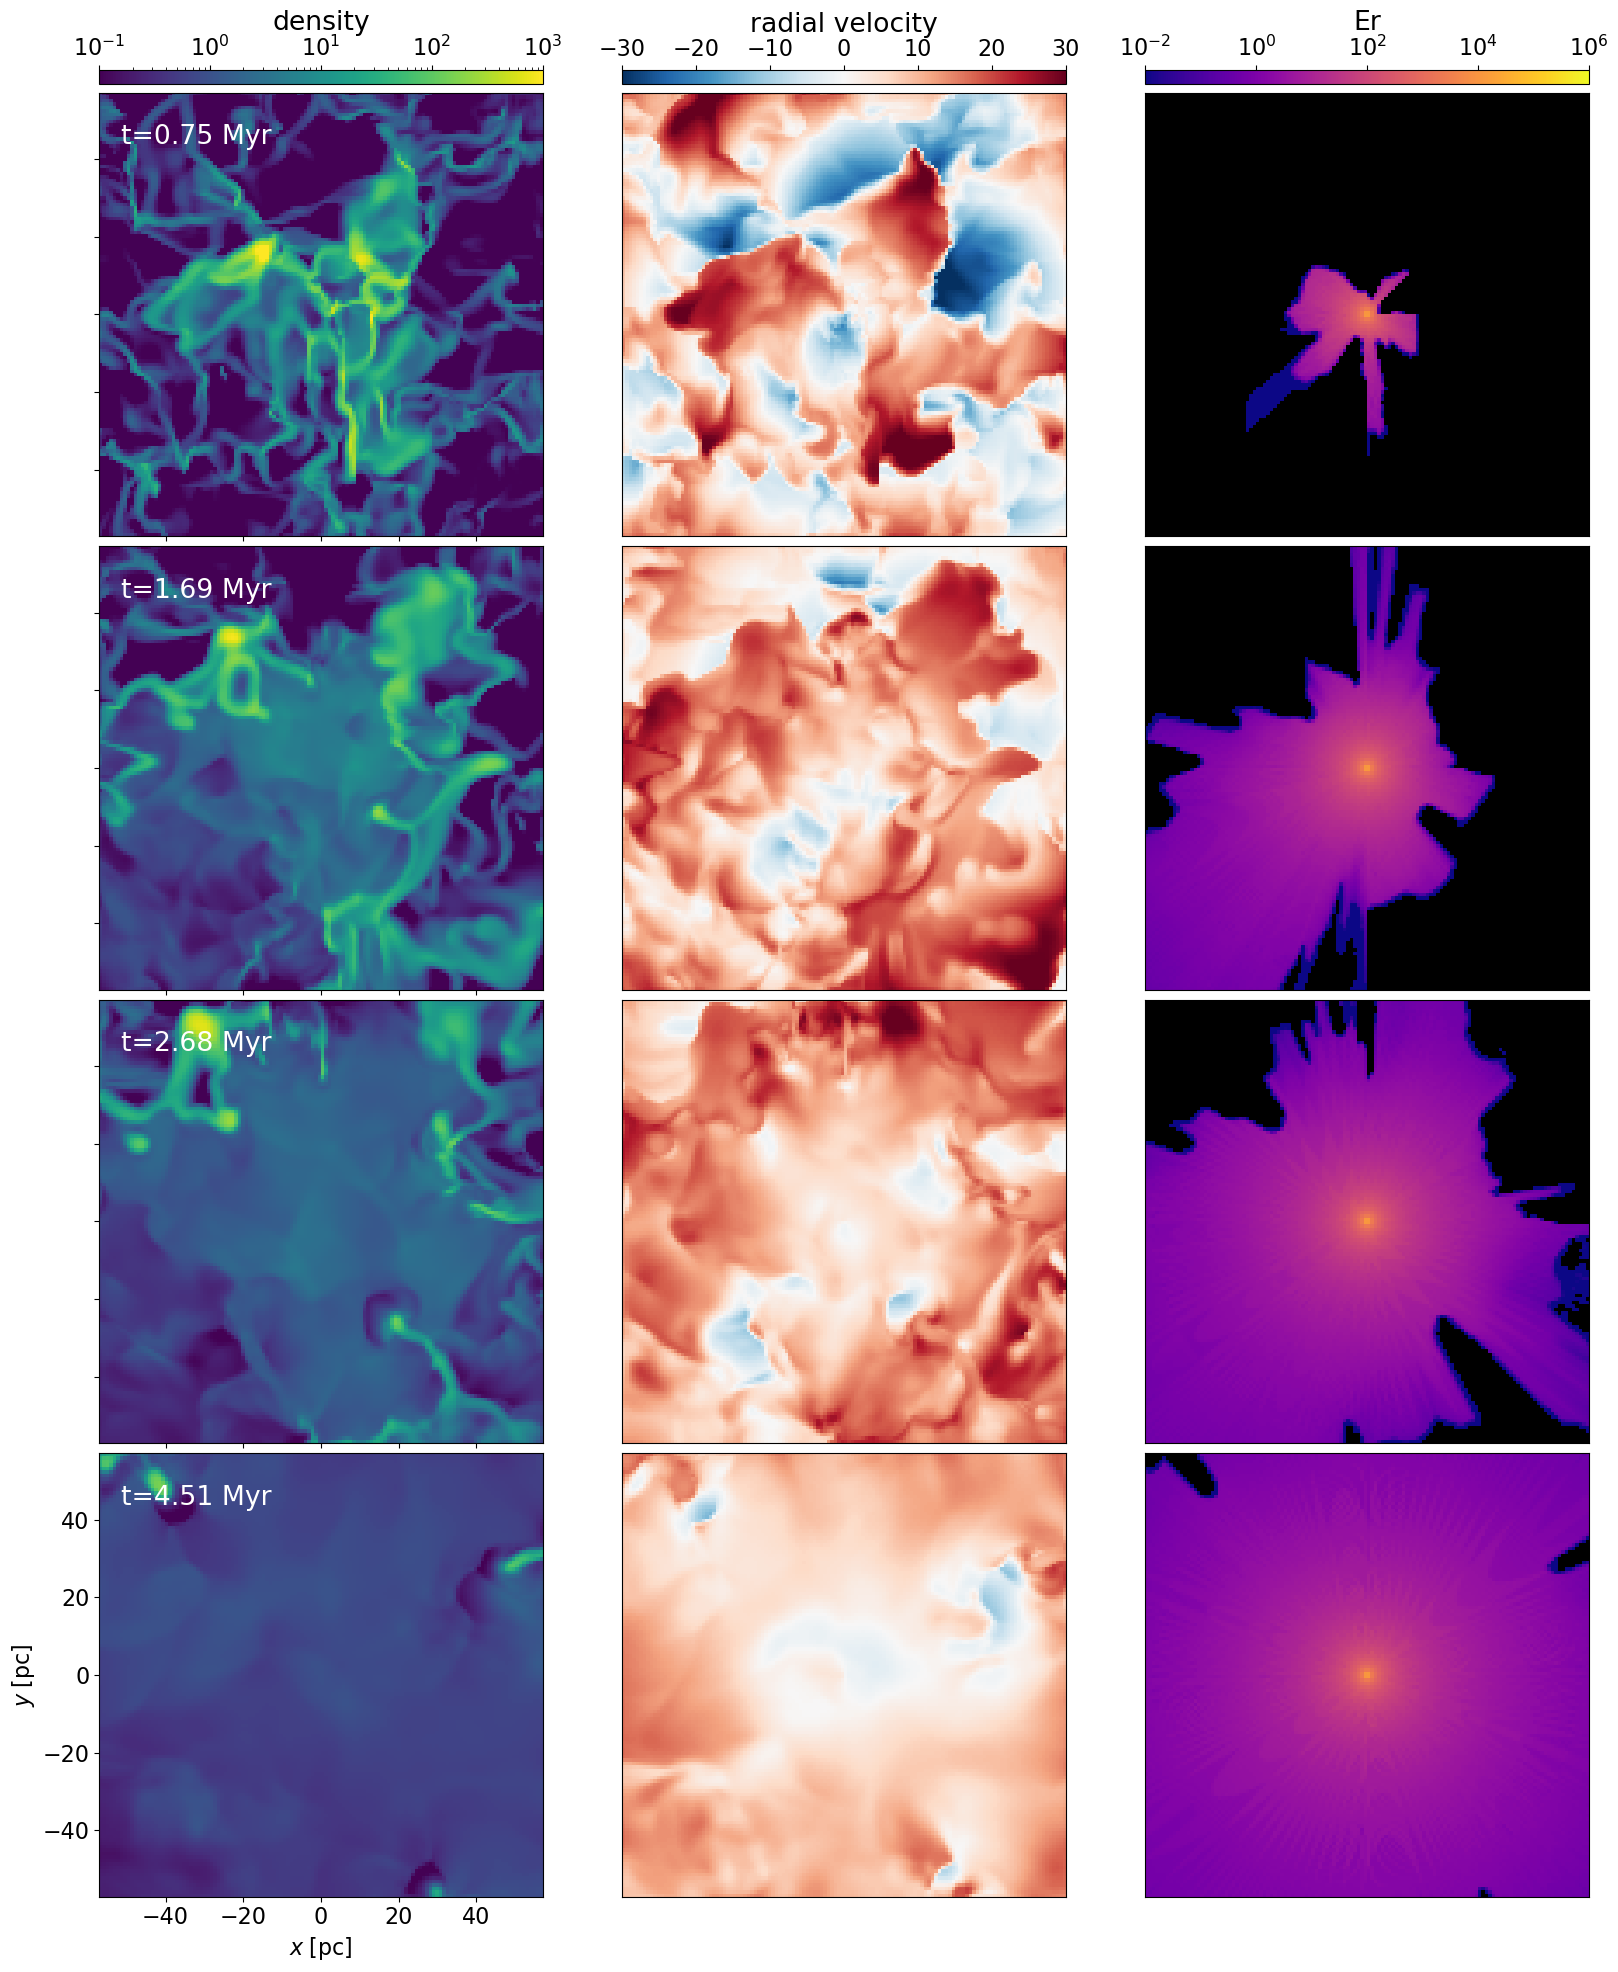

In [7]:
snapshot(pathlist1[0])

In [6]:
pathlist=[pathlist2[2],pathlist2[3],pathlist2[0]]#,pathlist2[1]]

In [7]:
def snapshot2(models):
    fig = plt.figure(figsize=(17,20))
    ImGrids=[]
    fields = [('density'),('vr'),('Er_rayt0')]
    nrow,ncol=len(models),len(fields)
    aux={}
    aux['density']={'cmap':'viridis','cmin':1e-1,'cmax':1e+3,'title':'density'}
    aux['vr']={'cmap':'RdBu_r','cmin':-30,'cmax':30,'title':'radial velocity'}
    aux['Er_rayt0']={'cmap':'plasma','cmin':1e-2,'cmax':1e+6,'title':'Er'}
    for icol,field in enumerate(fields):
        rect=str('1' + str(ncol) + str(1 + icol))
        #rect=[0.05 + 0.5*icol,0.05,0.05 + 0.5*icol + 0.45*icol,0.95]
        ImGrid=ImageGrid(fig,int(rect),nrows_ncols=(nrow,1),\
                     direction="row",\
                     axes_pad=0.1,label_mode="1",\
                     share_all = True,\
                     cbar_location="top",\
                     cbar_mode="single",\
                     cbar_size="3%",\
                     cbar_pad="2%",\
                     )
        ImGrids.append(ImGrid)
        for irow,model in enumerate(models):
            ax=ImGrid[irow]
            s = pa.LoadSim(str(model))
            t_ind = t_find(model)

            ds = s.load_hdf5(t_ind[2],load_method='yt')
            ad_grid = ds.covering_grid(level=0, left_edge=ds.domain_left_edge
                                , dims=ds.domain_dimensions)
            add_fields(ds,s)
            xmin,xmax=-s.par['mesh']['x1max'],s.par['mesh']['x1max']
            Z=ad_grid[field][:,:,s.par['mesh']['nx3']//2]
            if field=='vr':
                norm=mpl.colors.Normalize(vmin=aux[field]['cmin'],vmax=aux[field]['cmax'])
            else:
                norm=mpl.colors.LogNorm(vmin=aux[field]['cmin'],vmax=aux[field]['cmax'])
            p0=ax.imshow(Z.T,cmap=aux[field]['cmap'],norm=norm,origin='lower',
                         extent=[xmin,xmax,xmin,xmax])
            ax.patch.set_facecolor('black')
            
            ax.set_xlim(xmin,xmax)
            ax.set_ylim(xmin,xmax)
            # Add colorbar
            cb1=plt.colorbar(p0,cax=ImGrid.cbar_axes[0],orientation="horizontal")
            cb1.set_label(aux[field]['title'],fontsize=1.2*mpl.rcParams['font.size'])
            cb1.ax.xaxis.set_ticks_position('top')
            cb1.ax.xaxis.set_label_position('top')

            annot= '$v_{esc,0}/c_i=$'+str(str(model).split('/')[-1].split('_')[-1])+r",t=" + "{0:.2f}".format(ds.current_time.to('Myr'))
            if icol == 0:
                ax=ImGrid[irow]
                ax.annotate(annot,xy=(0.05,0.87),ha="left", va="bottom",color='white',\
                    xycoords=ax.transAxes,fontsize=mpl.rcParams['font.size']*1.2)

    ax=ImGrids[0][nrow-1]
    ax.set_xlabel(r'$x\;{\rm [pc]}$')
    ax.set_ylabel(r'$y\;{\rm [pc]}$')
    for icol in range(1,ncol):
        ax=ImGrids[icol][nrow-1]
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

    fig.tight_layout(w_pad=0.01)
    return

/tmp/ipykernel_150464/1232773938.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.01)


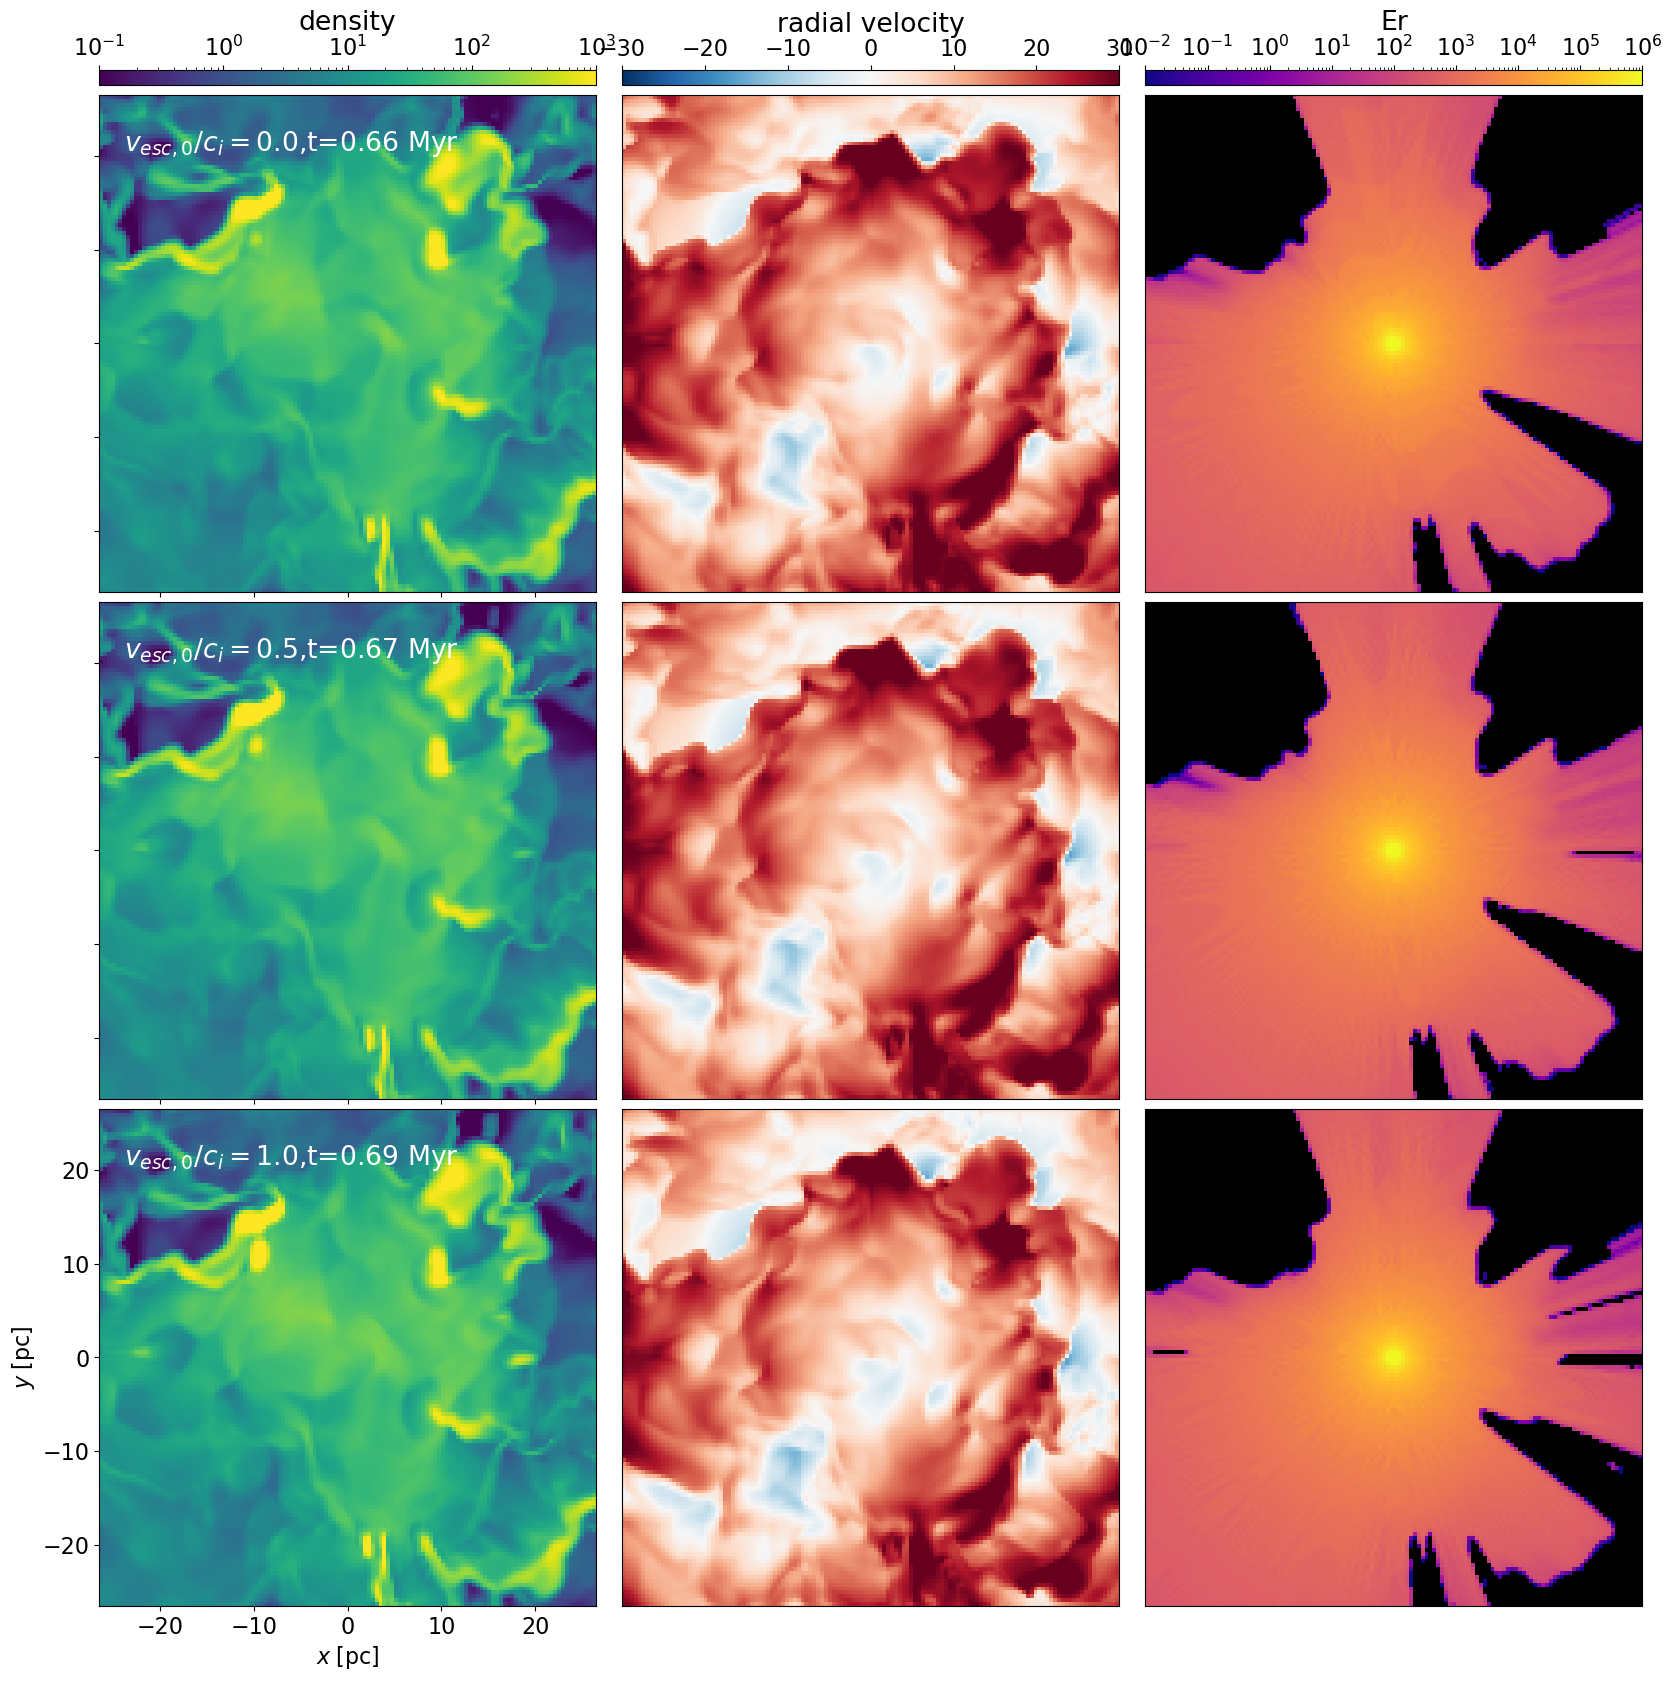

In [10]:
snapshot2(pathlist)

In [8]:
def cal_phi(xi,yi):
    arctan=np.abs(np.arctan(yi/xi))
    if (xi<0)&(yi>0):
        arctan=np.pi-arctan
    elif (xi<0)&(yi<0):
        arctan+=np.pi
    elif (xi>0)&(yi<0):
        arctan=2*np.pi-arctan
    return arctan

def projectionplot(field,ax_num):
    return np.sum(field,axis=ax_num)

def hammer(theta,phi):
    lat=theta-np.pi/2
    factor=np.sqrt(1+np.cos(phi)*np.cos(lat/2))
    x=2*np.sqrt(2)*np.cos(phi)*np.sin(lat/2)/factor
    y=np.sqrt(2)*np.sin(phi)/factor
    return x,y
def project(theta,phi):
    x=np.cos(theta)*np.cos(phi)
    y=np.cos(theta)*np.sin(phi)
    return x,y

In [11]:
c=(2.997925*10**10)*yu.cm/yu.s

In [14]:
def snapshot3(model):
    t_ind = t_find(model)
    s = pa.LoadSim(str(model))
    datapath_=Path(str(model)+'/evap_dictionary')
    pathlist_dict=list(datapath_.glob('*t*'))
    xmax=s.par['mesh']['x1max']
    dx=xmax/(s.par['mesh']['nx1']/2)
    fig, axes = plt.subplots(len(t_ind), 3, figsize=(15,18), constrained_layout=True,
            gridspec_kw=dict(width_ratios=[0.7,0.7,0.7]))#,height_ratios=[0.03,0.8]))
    plt.subplots_adjust(left=0.0,
            bottom=0.0, 
            right=1.0, 
            top=1.0, 
            wspace=0.0,
            hspace=0.0)

    for num in range(len(t_ind)):
        ds=s.load_hdf5(t_ind[num],load_method='yt')
        add_fields(ds,s)
        ad=ds.all_data()
        ad_grid = ds.covering_grid(level=0, left_edge=ds.domain_left_edge
                                , dims=ds.domain_dimensions)
        dx=ad_grid['dz']
        Sig=projectionplot(ad_grid['rho']*dx*s.u.mass.value,2)
        Em=projectionplot(ad_grid['ne^2']*dx/s.par['units']['length_cgs']**6,2)
        cmap1=mpl.cm.Spectral_r
        norm1=mpl.colors.LogNorm(vmin=1,vmax=1e+3)
        den=axes[num][0].imshow(Sig,cmap=cmap1,norm=norm1,origin='lower',extent=[-xmax,xmax,-xmax,xmax])
        if num==len(t_ind)-1:
            axes[num][0].set_xlabel(r'$\rm x(pc)$')
            axes[num][0].set_ylabel(r'$\rm y(pc)$')
        piece=str(model).split('/')[-1].split('_')
    
        if num==0:
            cb1=plt.colorbar(den, ax=axes[num][0],shrink=0.85,location='top',pad=0.0,ticklocation='top',orientation='horizontal')
            cb1.set_ticks(np.array([1,1e+1,1e+2,1e+3]))
            cb1.set_label(piece[1]+' '+piece[-2]+'='+piece[-1]+'\n'+r'$\Sigma \rm(M_{sun}/pc^2)$',fontsize=mpl.rcParams['font.size'])
        if num!=3:
            axes[num][0].set_xticks(np.array([-20,0,20]),'')
            axes[num][0].set_yticks(np.array([-20,0,20]),'')
        cmap2=mpl.cm.plasma
        norm2=mpl.colors.LogNorm(vmin=1e-1,vmax=1e+6)
        em=axes[num][1].imshow(Em,cmap=cmap2,norm=norm2,origin='lower',extent=[-xmax,xmax,-xmax,xmax])
    
        axes[num][1].set_xticks(np.array([-20,0,20]),'')
        axes[num][1].set_yticks(np.array([-20,0,20]),'')
        axes[num][1].patch.set_facecolor('black')
        if num==0:
            cb2=plt.colorbar(em, ax=axes[num][1], shrink=0.85,pad=0.0,location='top',ticklocation='top',orientation='horizontal')
            cb2.set_ticks(np.array([1e-1,1e+1,1e+3,1e+5]))
            cb2.set_label(r'$\int n^2_e dl \rm(pc/cm^6)$',fontsize=mpl.rcParams['font.size'])

        ph=str(pathlist_dict[t_ind[num]])
        with open(ph, 'rb') as fr:
            rr = pickle.load(fr)
        r0=rr['r0']
        sp2=ds.sphere([0,0,0],r0/0.95)
        Er=sp2.extract_isocontours('radius',r0,None,False,'Er_rayt0')[1]

        x=rr['x']
        y=rr['y']
        z=rr['z']
        f_esc_Om=rr['f_esc_Om']
        x_,y_=x[z>0],y[z>0]
        norm3=plt.Normalize(0, 1.01)
        cmap3=mpl.cm.viridis
        f_esc=axes[num][2].scatter(x_,y_,s=1,c=cmap3(norm3(f_esc_Om[z>0])))

        axes[num][2].set_xticks(np.array([-20,0,20]),'')
        axes[num][2].set_yticks(np.array([-20,0,20]),'')
        if num==0:
            cb3=plt.colorbar(f_esc,ax=axes[num][2],shrink=1.0,pad=0.0,location='top',ticklocation='top',orientation='horizontal')
            cb3.set_ticks(np.array([0,0.25,0.5,0.75]))
            cb3.set_label(r'$\rm f_{esc}$',fontsize=mpl.rcParams['font.size'])
        axes[num][0].text(-0.9*xmax,0.8*xmax,'t={:.3f}'.format(ds.current_time.to('Myr')),fontsize=mpl.rcParams['font.size'])
    return

/tmp/ipykernel_179910/2849030949.py:10: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.0,


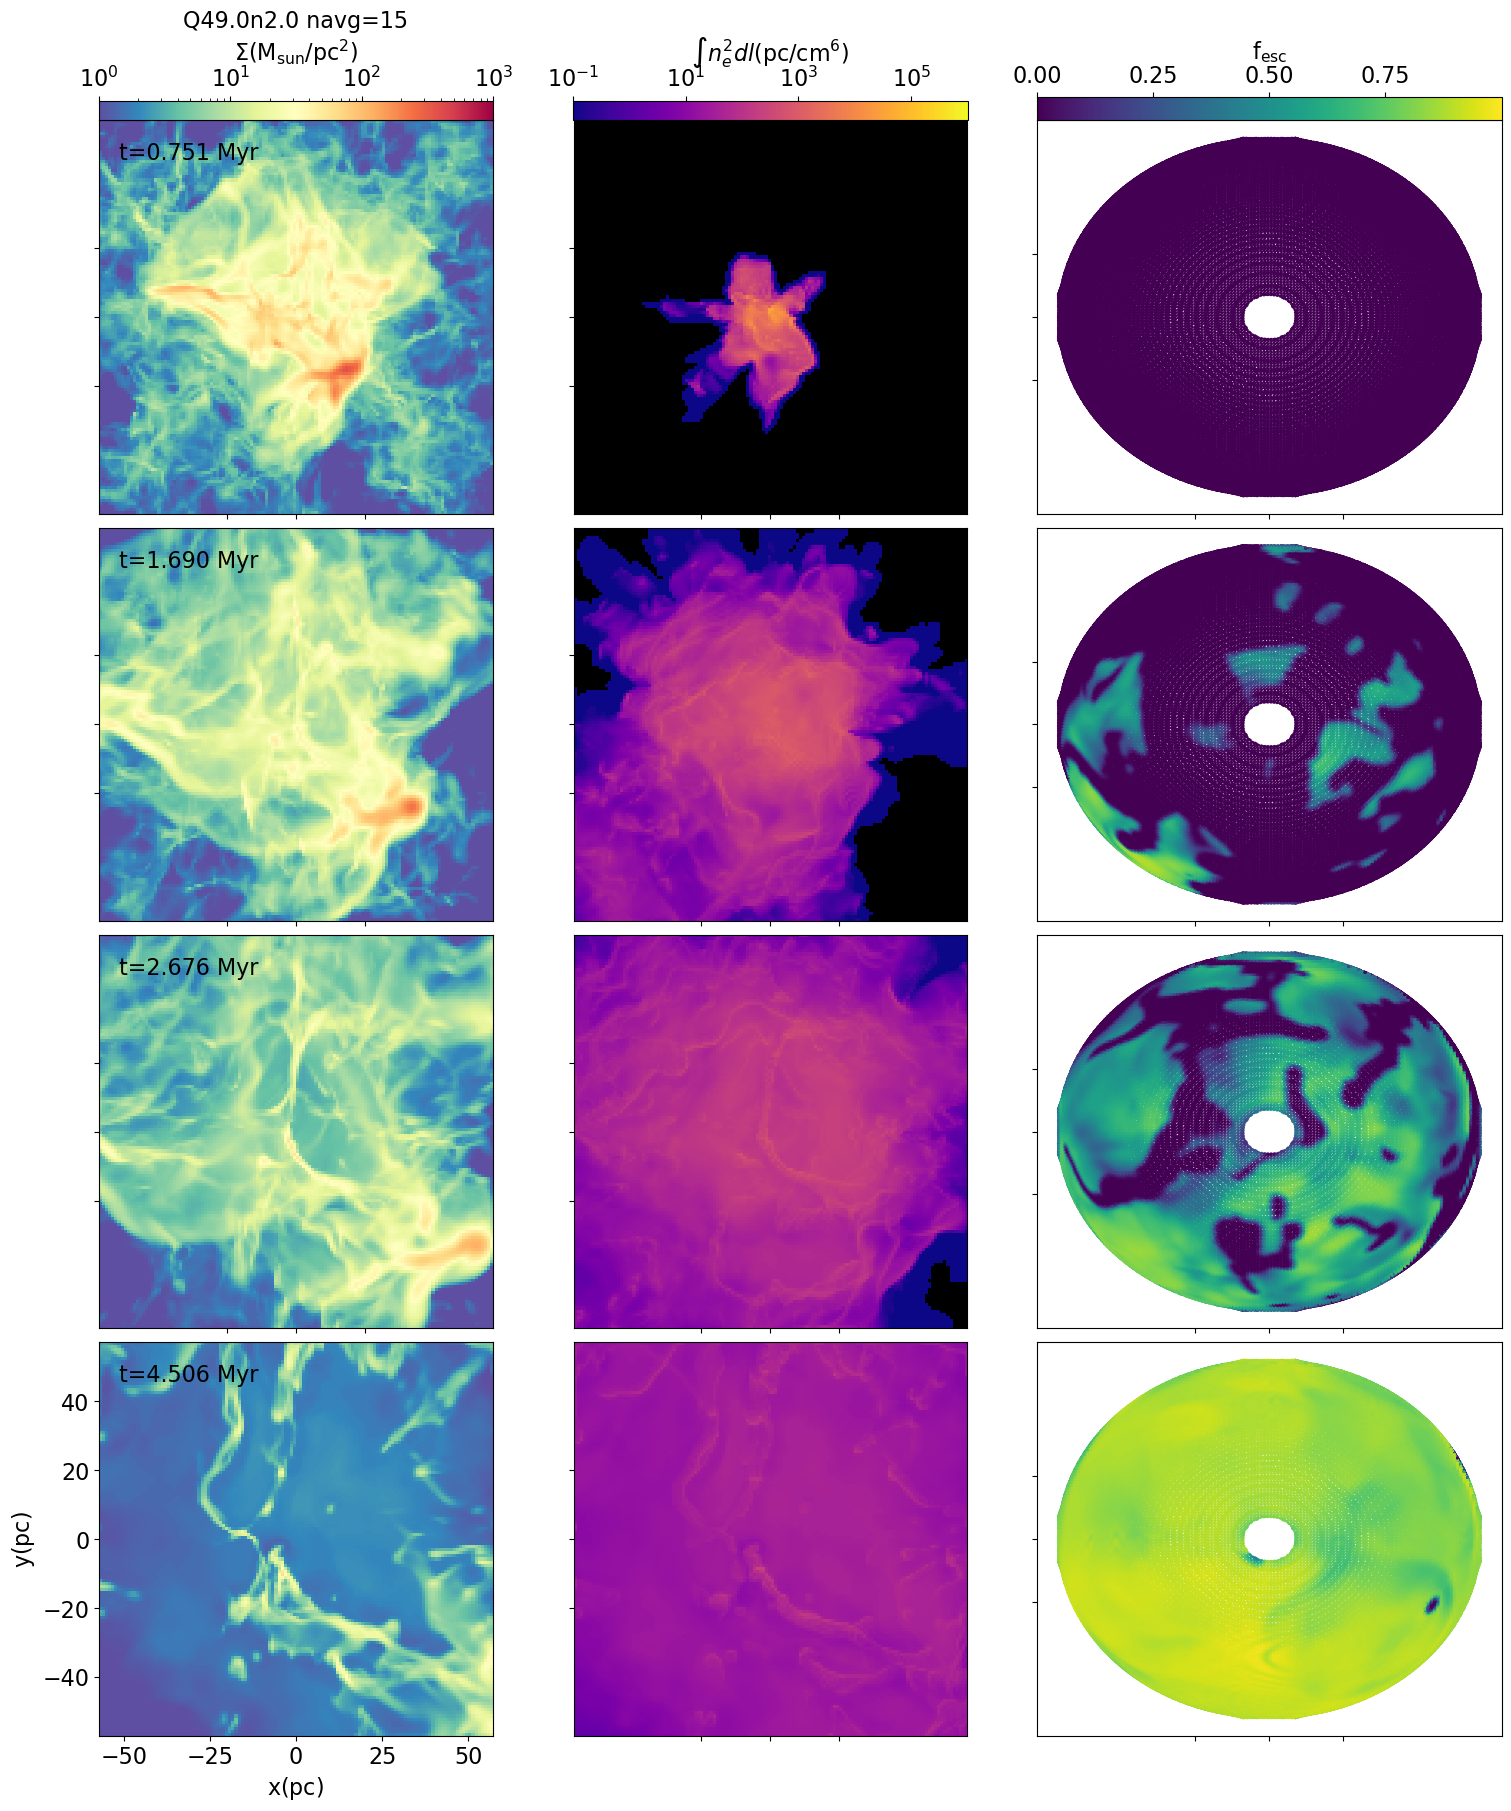

In [15]:
snapshot3(pathlist1[0])

## 3. history plot

In [95]:
def mass_history(model):
    fig=plt.figure()
    s = pa.LoadSim(str(model))
    h = pa.read_hst(s.files['hst'])
    M0 = h['mass'][0]
    plt.plot(h['time'],h['mass_neu']/M0,label='$M_{box,neu}$')
    plt.plot(h['time'],h['mass_ion']/M0,label='$M_{box,ion}$')
    dt=np.array(h['time'][1:])-np.array(h['time'][:-1])
    mass_out_ion = np.array([np.sum((h['dot_mass_out_ion'][:-1]*dt)[:k]) for k in range(len(dt))])
    mass_out_neu = np.array([np.sum((h['dot_mass_out_neu'][:-1]*dt)[:k]) for k in range(len(dt))])
    mass_evap = np.array([np.sum((h['dot_mass_ion'][:-1]*dt)[:k]) for k in range(len(dt))])
    plt.plot(h['time'][:-1],mass_out_ion/M0,label='$M_{out,ion}$')
    plt.plot(h['time'][:-1],mass_out_neu/M0,label='$M_{out,neu}$')
    plt.plot(h['time'][:-1],mass_evap/M0,label='$M_{evap}$')
    
    plt.xlabel('time')
    plt.ylabel('$M/M_0$')
    plt.legend(loc='upper right')
    plt.title(str(model).split('/')[-1],fontsize=12)
    return

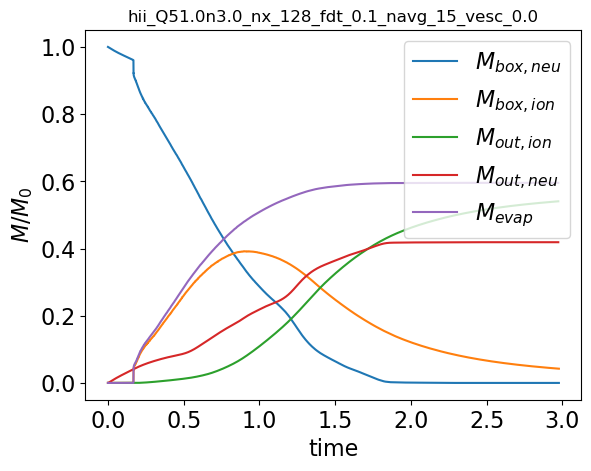

In [96]:
mass_history(pathlist[0])

In [112]:
def f_history(model):
    s=pa.LoadSim(str(model))
    t_arr=np.array([])
    fV_ion=np.array([])
    f_thick=np.array([])
    f_thin_esc=np.array([])
    f_esc=np.array([])
    datapath_=Path(str(model)+'/evap_dictionary')
    pathlist_dict=list(datapath_.glob('*t*'))
    f_crit=0.1
    for num in s.nums[::5]:
        ph=str(pathlist_dict[num])
        with open(ph, 'rb') as fr:
            rr = pickle.load(fr)
        r0=rr['r0']
        t_arr=np.hstack([t_arr,rr['time']])
        x,y,z=rr['x'],rr['y'],rr['z']
        surf=rr['surf_triangle']
        w1 = surf[:,1] - surf[:,0]
        w2 = surf[:,1] - surf[:,2]
        vector_area=np.cross(w1, w2)/2
        scalar_area=np.sqrt(np.sum(vector_area**2,axis=1))
        Omega=scalar_area/r0**2
        f_esc_Om=np.array(rr['f_esc_Om'])
        f_thick=np.hstack([f_thick,np.sum(Omega[f_esc_Om<f_crit])/4/np.pi])
        val=np.sum((f_esc_Om*Omega)[f_esc_Om>f_crit])/np.sum((Omega)[f_esc_Om>f_crit])
        f_thin_esc=np.hstack([f_thin_esc,val])
        f_esc=np.hstack([f_esc,rr['f_esc']])
        ds=s.load_hdf5(num,load_method='yt')
        ad=ds.all_data()
        fV=np.sum(ad['cell_volume'][(ad['r0']<0.5)&(ad['radius']<r0)])/np.sum(ad['cell_volume'][ad['radius']<r0])
        fV_ion=np.hstack([fV_ion,fV])

    fig=plt.figure()
    plt.plot(t_arr,fV_ion,label='$f_{V,ion}$')
    plt.plot(t_arr,1-f_thick,label='$f_{thin}$')
    plt.plot(t_arr,f_thin_esc,label='$f_{thin,esc}$')
    plt.plot(t_arr,f_esc,label='$f_{esc,total}$')
    plt.plot(t_arr,(1-f_thick)*f_thin_esc,label='$f_{thin}\\times f_{thin,esc}$')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('fraction')
    return

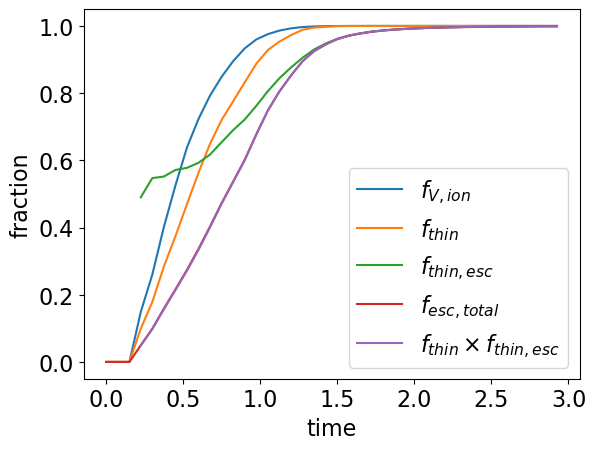

In [113]:
f_history(pathlist[0])